Modelo LSTM para prever o parâmetro Turbidez 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams.update({'font.size':18})

In [4]:
str_files = ''

#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'turbidez.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [5]:
#df.head()

In [6]:
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']
#z.info()

In [7]:
z = z.dropna(axis=1,how='any')
#for field in z.columns:
    #print(field,'NaN',z[field].isnull().sum())
#print(len(z))

In [8]:
trainingd = z.resample('3M').mean()
trainingd
data = trainingd.iloc[:,1:2].values

train = trainingd.iloc[0:133,1:2].values  
test = trainingd.iloc[133:,1:2].values   
print('treino:',len(train))
print('teste:',len(test))
len(test)

treino: 133
teste: 33


33

In [9]:
sc = MinMaxScaler()
train_normalizado = sc.fit_transform(train)

In [10]:
timestamp = 8
previsores = []
turbidez_real    = []
for i in range(timestamp, len(train)):
    previsores.append(train_normalizado[i-timestamp:i, 0])
    turbidez_real.append(train_normalizado[i, 0])
previsores, turbidez_real = np.array(previsores), np.array(turbidez_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(125, 8, 1)

In [11]:
print("Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, turbidez_real, epochs = 100, batch_size = 32)


Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 108ms/sample - loss: 0.0473
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0395
Epoch 3/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0273
Epoch 5/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0256
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0258
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0265
Epoch 9/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0252
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0237


In [12]:
turbidez_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

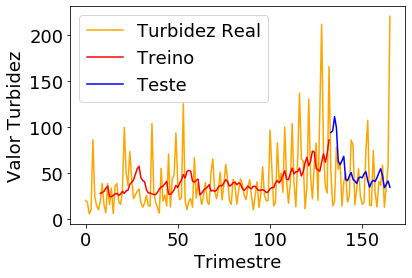

In [13]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='Turbidez Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor Turbidez')
plt.legend(loc='best')
plt.show()

In [14]:
print('Previsão (média):',round(previsoes.mean(),2))
print('Turbidez Real (média):', round(turbidez_real_teste.mean(),2))
print('Diferença (média):', round(turbidez_real_teste.mean() - previsoes.mean(),2))

Previsão (média): 52.52
Turbidez Real (média): 46.72
Diferença (média): -5.8


In [15]:
train_score10 = model.evaluate(previsores, turbidez_real, verbose=0)
ph10_mse  = train_score10
ph10_rmse = math.sqrt(train_score10)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score10, math.sqrt(train_score10)))
#test_score10 = mdl.evaluate(X_test, y_test, verbose=0)
#print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score10, math.sqrt(test_score10)))

Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [16]:
print("Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 25, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, turbidez_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 110ms/sample - loss: 0.0443
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0318
Epoch 3/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0265
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0261
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0238
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0255
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0264
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0249
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0250
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0236
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0228


In [17]:
turbidez_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

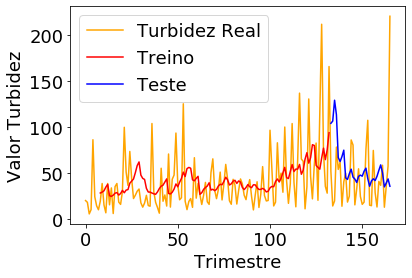

Previsão (média): 56.25
Turbidez Real (média): 46.72
Diferença (média): -9.53
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [18]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='Turbidez Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor Turbidez')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('Turbidez Real (média):', round(turbidez_real_teste.mean(),2))
print('Diferença (média):', round(turbidez_real_teste.mean() - previsoes.mean(),2))

train_score25 = model.evaluate(previsores, turbidez_real, verbose=0)
ph25_mse  = train_score25
ph25_rmse = math.sqrt(train_score25)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score25, math.sqrt(train_score25)))


In [19]:
print("Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, turbidez_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 113ms/sample - loss: 0.0420
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0238
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0275
Epoch 4/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0252
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0244
Epoch 6/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0259
Epoch 7/100
125/125 [==============================] - 1s 4ms/sample - loss: 0.0257
Epoch 8/100
125/125 [==============================] - 1s 5ms/sample - loss: 0.0239
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0238
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0236
Epoch 11/100
125/125 [==============================] - 

Epoch 96/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0228


In [20]:
turbidez_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

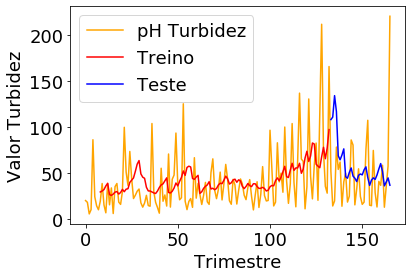

Previsão (média): 57.89
Turbidez Real (média): 46.72
Diferença (média): -11.17
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [22]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='pH Turbidez', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor Turbidez')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('Turbidez Real (média):', round(turbidez_real_teste.mean(),2))
print('Diferença (média):', round(turbidez_real_teste.mean() - previsoes.mean(),2))

train_score50 = model.evaluate(previsores, turbidez_real, verbose=0)
ph50_mse  = train_score50
ph50_rmse = math.sqrt(train_score50)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score50, math.sqrt(train_score50)))
    


In [23]:
ph_media_mse = (ph10_mse+ph25_mse+ph50_mse)/3
ph_media_rmse = (ph10_rmse+ph25_rmse+ph50_rmse)/3

print('Turbidez_media_mse:', round(ph_media_mse,3))
print('Turbidez_media_rmse:', round(ph_media_rmse,3))

Turbidez_media_mse: 0.022
Turbidez_media_rmse: 0.149
